In [1]:
#1
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import rasterio

from src.step2_ndvivariance import (
    load_all_data,
    compute_ndvi_temporal_features,
    compute_ndvi_variance_mask,
)
from src.config import IMAGES_DIR, MASKS_DIR


In [2]:
#2
dataset = load_all_data()

print("Loaded items:", len(dataset))
for item in dataset:
    print(f"Image {item['id']} -> NDVI time steps: {item['n_timesteps']}")


[Step-0] Image 1022: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0545
[Step-0] Image 1023: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0160
[Step-0] Image 1024: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0439
[Step-0] Image 1027: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0587
[Step-0] Image 1028: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0463
[Step-0] Image 1029: NDVI time-series loaded (T=6) | NDVI variance threshold=0.1050
[Step-0] Image 1031: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0850
[Step-0] Image 1032: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0618
[Step-0] Image 1099: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0321
[Step-0] Image 1100: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0355
[Step-0] Image 1101: NDVI time-series loaded (T=6) | NDVI variance threshold=0.0923
[Step-0] Image 1103: NDVI time-series loaded (T=6) | NDVI variance threshold

In [3]:
#3 
item = dataset[0]   # first image
img_id = item["id"]

ndvi_ts   = item["ndvi_ts"]
ndvi_mean = item["ndvi_mean"]
ndvi_var  = item["ndvi_var"]

print("Image:", img_id)
print("NDVI cube shape:", ndvi_ts.shape)    # expect (T, H, W)


Image: 1022
NDVI cube shape: (6, 256, 256)


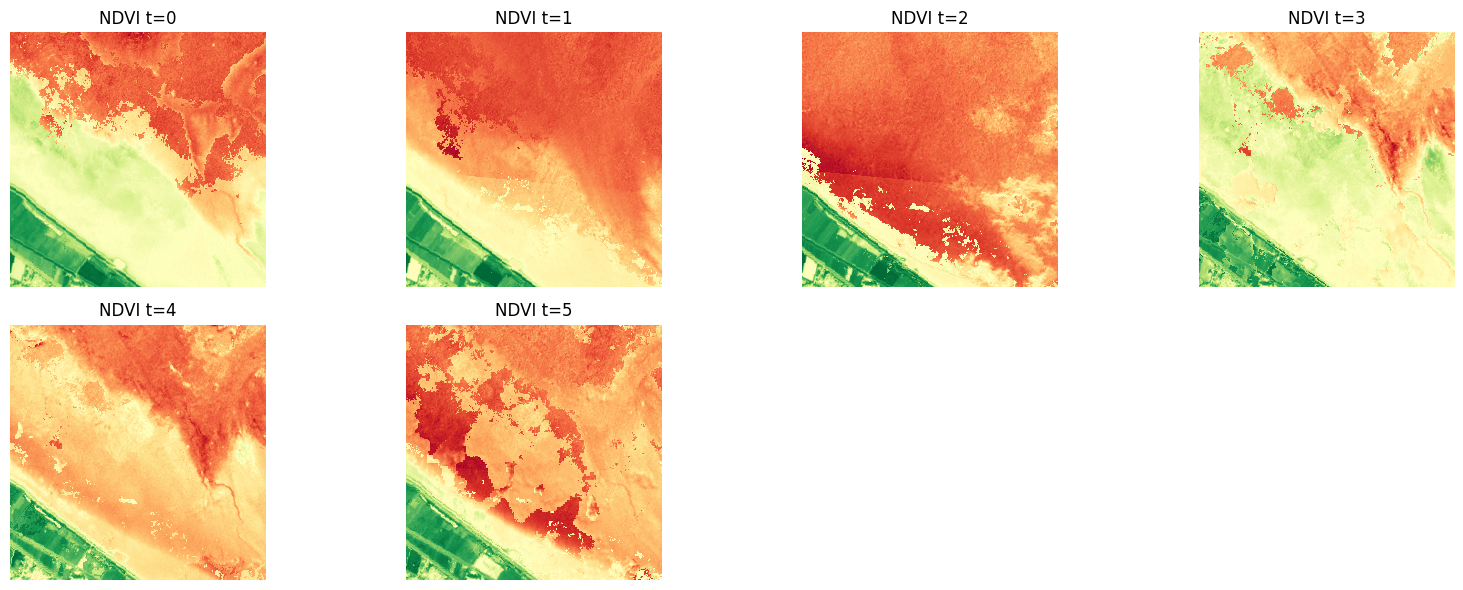

In [4]:
#4
T = ndvi_ts.shape[0]
cols = 4
rows = int(np.ceil(T / cols))

plt.figure(figsize=(16, 3*rows))

for t in range(T):
    plt.subplot(rows, cols, t+1)
    plt.imshow(ndvi_ts[t], cmap="RdYlGn")
    plt.title(f"NDVI t={t}")
    plt.axis("off")

plt.tight_layout()
plt.show()


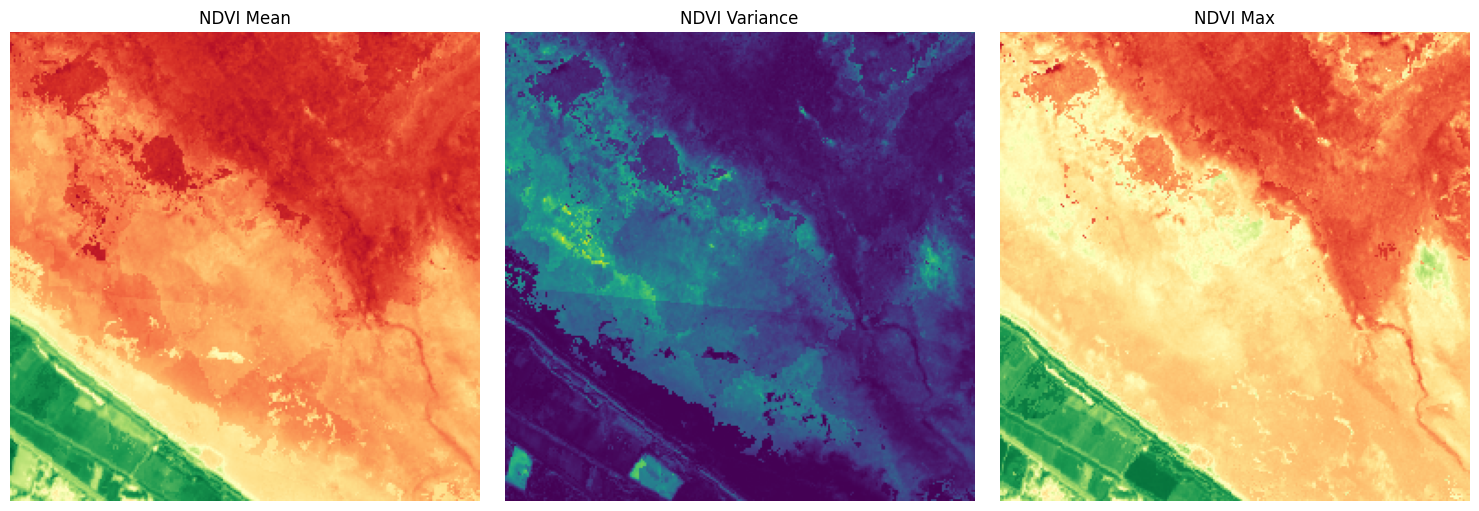

In [5]:
#5
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(ndvi_mean, cmap="RdYlGn")
plt.title("NDVI Mean")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(ndvi_var, cmap="viridis")
plt.title("NDVI Variance")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(ndvi_ts.max(axis=0), cmap="RdYlGn")
plt.title("NDVI Max")
plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
mask, thr, mu, sigma = compute_ndvi_variance_mask(ndvi_var, alpha=1.0)

print("Variance threshold:", thr)
print("Mean:", mu, "Std:", sigma)
print("Mask active pixels:", mask.sum())


Variance threshold: 0.054537937
Mean: 0.0293116 Std: 0.02522634
Mask active pixels: 12377


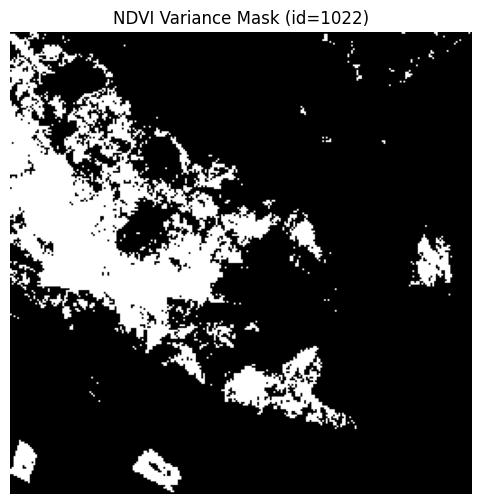

In [7]:
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")
plt.title(f"NDVI Variance Mask (id={img_id})")
plt.axis("off")
plt.show()


In [13]:
from src.superpixels_temporal import generate_temporal_superpixels
labels, centroids, sal = generate_temporal_superpixels(
    rgb=item["rgb"],
    ndvi_ts=item["ndvi_ts"]
)


labels shape: (256, 256)
centroids: 148


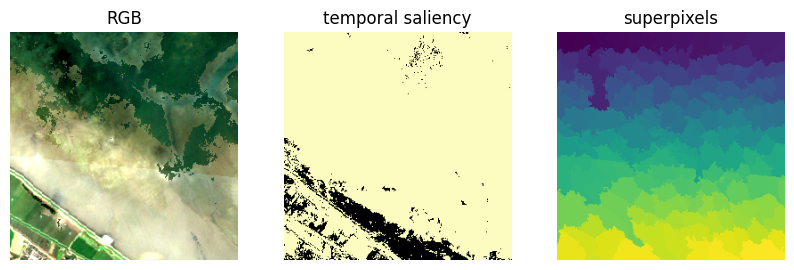

In [14]:
from src.superpixels_temporal import generate_temporal_superpixels

# test single image item
item = dataset[0]   # or iterate over any item from load_all_data()
labels, centroids, sal = generate_temporal_superpixels(
    rgb = item["rgb"],
    ndvi_ts = item["ndvi_ts"],
    n_segments = 200  # tune this: 100-400 typical
)

print("labels shape:", labels.shape)
print("centroids:", len(centroids))

# visualize quickly
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(item["rgb"]); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(sal, cmap="magma"); plt.title("temporal saliency"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(labels); plt.title("superpixels"); plt.axis("off")
plt.show()

In [15]:
from src.config import TEMPORAL_PROMPTS_DIR

os.makedirs(TEMPORAL_PROMPTS_DIR, exist_ok=True)

np.save(
    os.path.join(TEMPORAL_PROMPTS_DIR, f"superpixel_prompts_{item['id']}.npy"),
    np.array(centroids)
)


In [16]:
# Generate and save centroids prompts for all dataset items.
# Cell: Generate temporal superpixel prompts for all images

from src.superpixels_temporal import generate_temporal_superpixels, save_temporal_centroids
from src.config import TEMPORAL_PROMPTS_DIR
import numpy as np
import os

os.makedirs(TEMPORAL_PROMPTS_DIR, exist_ok=True)

all_results = {}

for item in dataset:   # dataset from Step-0 loader

    image_id = item["id"]
    ndvi_ts  = item["ndvi_ts"]
    rgb      = item["rgb"]          # must already exist in dataset

    print(f"\n[Temporal-SPX] Processing image {image_id}")

    labels, centroids, saliency = generate_temporal_superpixels(
        rgb=rgb,
        ndvi_ts=ndvi_ts,
        n_segments=1200,
        compactness=0.1,
        var_thresh=0.05,
        peak_thresh=0.15
    )

    out_path = save_temporal_centroids(
        image_id=image_id,
        centroids=centroids
      #  out_dir=TEMPORAL_PROMPTS_DIR
    )

    all_results[image_id] = {
        "n_centroids": len(centroids),
        "centroid_path": out_path
    }

print("\n✅ Temporal superpixel prompts generated for all images")



[Temporal-SPX] Processing image 1022
[Temporal SPX] Saved 1102 centroids → d:\project_alpha\data\results\temporal_prompts\superpixel_prompts_1022.npy

[Temporal-SPX] Processing image 1023
[Temporal SPX] Saved 1095 centroids → d:\project_alpha\data\results\temporal_prompts\superpixel_prompts_1023.npy

[Temporal-SPX] Processing image 1024
[Temporal SPX] Saved 793 centroids → d:\project_alpha\data\results\temporal_prompts\superpixel_prompts_1024.npy

[Temporal-SPX] Processing image 1027
[Temporal SPX] Saved 1071 centroids → d:\project_alpha\data\results\temporal_prompts\superpixel_prompts_1027.npy

[Temporal-SPX] Processing image 1028
[Temporal SPX] Saved 756 centroids → d:\project_alpha\data\results\temporal_prompts\superpixel_prompts_1028.npy

[Temporal-SPX] Processing image 1029
[Temporal SPX] Saved 944 centroids → d:\project_alpha\data\results\temporal_prompts\superpixel_prompts_1029.npy

[Temporal-SPX] Processing image 1031
[Temporal SPX] Saved 880 centroids → d:\project_alpha\data\

In [17]:


# Cell: Rank temporal prompts for all images

from src.rank_temporal_prompts import rank_temporal_prompts, save_ranked_prompts
from src.superpixels_temporal import generate_temporal_superpixels
from src.config import RANKED_PROMPTS_DIR

import os
os.makedirs(RANKED_PROMPTS_DIR, exist_ok=True)

ranking_summary = {}

for item in dataset:

    image_id = item["id"]
    ndvi_ts  = item["ndvi_ts"]
    rgb      = item["rgb"]

    print(f"\n[RANK] Processing image {image_id}")

   # 1. Load filtered centroids
    centroids_path = os.path.join(TEMPORAL_PROMPTS_DIR, f"superpixel_prompts_{image_id}.npy")
    centroids = np.load(centroids_path).tolist()

    # Regenerate labels and saliency for ranking
    labels, _, saliency = generate_temporal_superpixels(
        rgb=rgb,
        ndvi_ts=ndvi_ts,
        n_segments=1200,
        compactness=0.1,
        var_thresh=0.05,
        peak_thresh=0.15
    )

    # 2. Rank prompts
    ranked = rank_temporal_prompts(
        labels=labels,
        centroids=centroids,
        saliency=saliency,
        top_k=100
    )

    # 3. Save ranked prompts
    out_path = save_ranked_prompts(image_id, ranked)

    ranking_summary[image_id] = {
        "n_ranked": len(ranked),
        "path": out_path
    }

print("\n✅ Ranked temporal prompts generated for ALL images")


[RANK] Processing image 1022
[RANK] Image 1022: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ranked\ranked_prompts_1022.npy

[RANK] Processing image 1023
[RANK] Image 1023: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ranked\ranked_prompts_1023.npy

[RANK] Processing image 1024
[RANK] Image 1024: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ranked\ranked_prompts_1024.npy

[RANK] Processing image 1027
[RANK] Image 1027: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ranked\ranked_prompts_1027.npy

[RANK] Processing image 1028
[RANK] Image 1028: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ranked\ranked_prompts_1028.npy

[RANK] Processing image 1029
[RANK] Image 1029: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ranked\ranked_prompts_1029.npy

[RANK] Processing image 1031
[RANK] Image 1031: saved 100 prompts → d:\project_alpha\data\results\temporal_prompts_ra

In [8]:
from src.step2_sam_run_temporal import run_sam_with_temporal_prompts

run_sam_with_temporal_prompts(dataset)


D:\segment-anything\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)



========== Step 2D: Running SAM with temporal Prompts ==========

Available variables in NL_1022.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']

[RUN-REFINED] Image 1022
  -> Temporal prompts=100, IoU=0.261, F1=0.414
Available variables in NL_1023.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']

[RUN-REFINED] Image 1023
  [SKIP] Image 1023: GT empty — not evaluated.
Available variables in NL_1024.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']

[RUN-REFINED] Image 1024
  -> Temporal prompts=100, IoU=0.061, F1=0.115
Available variables in NL_1027.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']

[RUN-REFINED] Image 1027
  -> Temporal prompts=100, IoU=0.000, F1=0.000
Available variables in NL_1028.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']

[RUN-REFINED] Image 1028
  -> Temporal prompts=100, IoU=0.274, F1=0.431
Available variables in NL_1029.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']

[RUN-REFINED] Image 1029
  -> Temporal prompts=100, IoU=0.041, F1=0.0